## 1. Import Library
___

In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score  


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_EMBEDDINGS_FROM = '/kaggle/input/chest-x-ray-image-embedding/'

2024-08-07 10:51:45.429189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 10:51:45.429301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:51:45.612449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


## 2. RAPIDS UMAP, KMeans
___
We will use `UMAP` to reduce these embeddings to two dimensions. Lastly we will use `KMeans`

### Load RAPIDS

In [5]:
import cudf, cuml, cupy
print('RAPIDS', cudf.__version__)

RAPIDS 24.06.01


### RAPIDS cudf
we will read train embedding into a RAPIDS cudf

**Train Dataset**

In [6]:
train_embedding = cudf.read_csv(f'{LOAD_EMBEDDINGS_FROM}resnet_train.csv')

**Test Dataset**

In [7]:
test_embedding = cudf.read_csv(f'{LOAD_EMBEDDINGS_FROM}resnet_test.csv')

In [8]:
embedding = cudf.concat([train_embedding, test_embedding])
embedding = embedding.drop(columns=['Fold'])

### RAPIDS UMAP
We will use UMAP to reduce embedding vetctors to two dimensions

In [9]:
%%time

from cuml import UMAP
umap = UMAP()
embed_2d = umap.fit_transform(embedding.drop(columns=['Image Index','Finding Labels','path']))
embed_2d = embed_2d.to_numpy()

CPU times: user 1min 21s, sys: 3.07 s, total: 1min 24s
Wall time: 1min 24s


### RAPIDS KMeans
We will use KMeans to find clusters of Lung Diseases.

In [10]:
from cuml import KMeans
kmeans = cuml.KMeans(n_clusters=9)
kmeans.fit(embed_2d)
embedding['cluster'] = kmeans.labels_

## 3. Display UMAP
We will display the result of UMAP which reduced text to two dimension.

In [11]:
from cuml.preprocessing import LabelEncoder
import cudf

labelencoder = LabelEncoder()
embedding['Finding Labels'] = labelencoder.fit_transform(embedding['Finding Labels'])

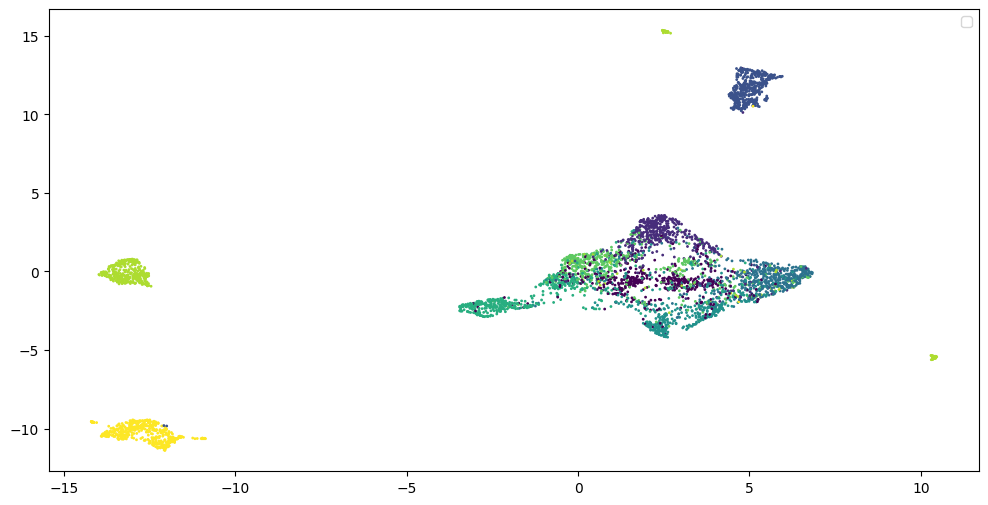

In [12]:
plt.figure(figsize=(12,6))

plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=embedding['Finding Labels'].to_numpy())
plt.legend()
plt.show()